<a href="https://colab.research.google.com/github/sid521/ML8-ImageCaptioning/blob/main/predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.spatial.distance import cdist
import matplotlib.image as mpimg
import os
import tensorflow as tf
import cv2
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
# from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D,Concatenate, ReLU, LeakyReLU,Reshape, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import categorical_accuracy,top_k_categorical_accuracy
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from keras.utils.data_utils import get_file
from tqdm import tqdm
import matplotlib.pyplot as plt
import collections
import random
import time
import json
from PIL import Image

## Load Resnet50

In [ ]:
image_features_extract_model = load_model('/content/resnet50_model.hdf5')

In [ ]:
image_features_extract_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
with open('/content/tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224)) # (224,224) is the default input of resnet50
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img, image_path

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512

# Shape of the vector extracted from resnet50 is (49, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 49

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 49, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 49, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 49, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 49, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # This encoder passes those features extracted from resnet50 (9,2048)through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
len(tokenizer.word_index)
inp = tf.expand_dims([tokenizer.word_index['<start>']], 0)

In [ ]:
vocab_size=5001
encoder = CNN_Encoder(embedding_dim)
encoder.call(np.zeros((49,2048)))
encoder.built=True
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
hidden = decoder.reset_state(batch_size=1)
decoder.call(inp,np.zeros((49,256)),hidden)
decoder.built=True

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
encoder.load_weights('/content/encoder.h5')
decoder.load_weights('/content/decoder.h5')

In [ ]:
max_length = 47
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (7, 7))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## Prediction

## Test your own images

In [ ]:
def predict(path):
    # the cosine similarity of a random image in the test dataset
    res, attention_plot = evaluate(path)
    plot_attention(path, res, attention_plot)
    res = ' '.join(res)
    result = res.replace('<end>',' ')
    print('Prediction Caption:', result)
    im = Image.open(path)
    plt.imshow(im)

(224, 224, 3)
(1, 224, 224, 3)


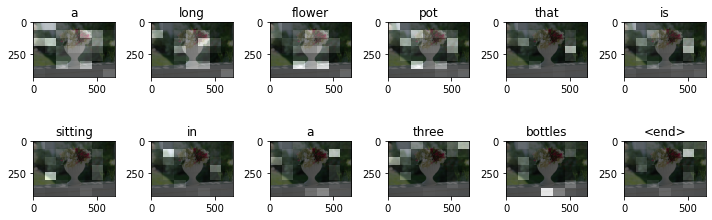

Prediction Caption: a long flower pot that is sitting in a three bottles  


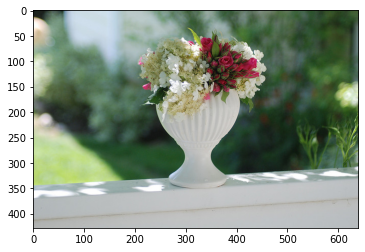

In [ ]:
path = '/content/test.jpg'
predict(path)

### For Validation and test sets of the coco data

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip) #remove zip file

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)# remove zip file
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 323s 0us/step


## Preprocessing the captions

In [ ]:
annotation_file = os.path.abspath('.')+'/annotations/captions_train2014.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>" 
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:]
print(len(train_image_paths))

82783


In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A white bathroom with granite countertops and white tile flooring. <end>


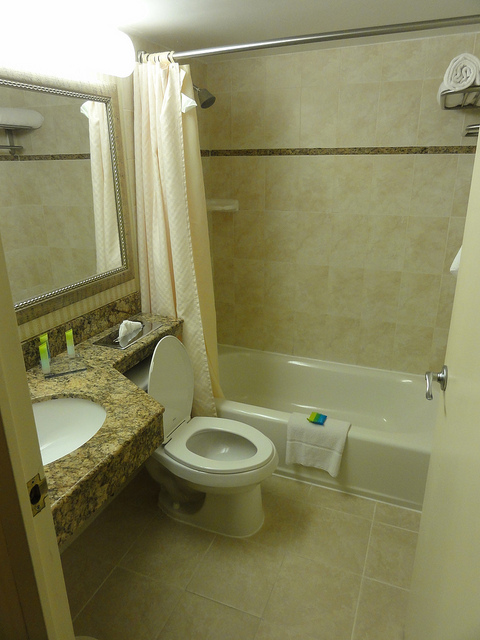

In [ ]:
print(train_captions[0])
Image.open(img_name_vector[0])

In [ ]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)
# Pad each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

img_name = []
cap = []
for img in img_keys:
  cap_len = len(img_to_cap_vector[img])
  img_name.extend([img] * cap_len)
  cap.extend(img_to_cap_vector[img])

(224, 224, 3)
(1, 224, 224, 3)
Real Caption: <start> home plate with a batter swinging in a baseball game <end>
Prediction Caption: resemble sandwich clock bicycle room <end>


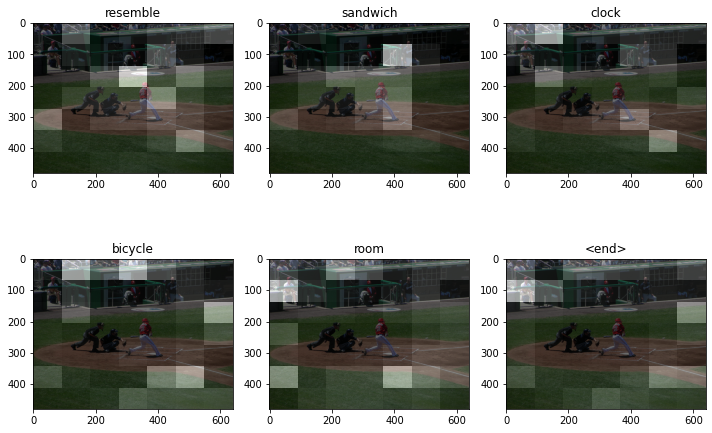

In [ ]:
rid = np.random.randint(0, len(img_name))
image = img_name[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [ ]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
# from scipy.spatial.distance import cdist
# import matplotlib.image as mpimg

     |████████████████████████████████| 92kB 5.0MB/s 
     |████████████████████████████████| 2.5MB 30.0MB/s 
     |████████████████████████████████| 1.2MB 39.0MB/s 
     |████████████████████████████████| 3.3MB 35.4MB/s 
     |████████████████████████████████| 901kB 42.1MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-cp37-none-any.whl size=126711 sha256=a2a08c76047cb935ee4b5be4a83fea00cbc9981a15dd644a986ba2beef924935
  Stored in directory: /root/.cache/pip/wheels/38/d2/98/d191289a877a34c68aa67e05179521e060f96394a3e9336be6
Successfully built sentence-transformers
ERROR: transformers 4.8.2 has requirement huggingface-hub==0.0.12, but you'll have huggingface-hub 0.0.13 which is incompatible.


In [ ]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
# the cosine similarity of a random image in the test dataset
def similarity_score(index=None,verbose = True,view_image=False):
  real_captions=[]
  if index== None or index>=len(img_name)  :
    rid = np.random.randint(0, len(img_name))
  else :
    rid = index
  image = img_name[rid]
  a=img_to_cap_vector[image]
  for cap in a:
    temp= ' '.join([tokenizer.index_word[i]
                            for i in cap if i not in [0]])
    temp=temp.replace('<start>',' ')
    temp=temp.replace('<end>',' ')
    real_captions.append(temp)
  result, attention_plot = evaluate(image)
  res = ' '.join(result)
  result = res.replace('<end>',' ')
  encodings=model.encode(real_captions)
  result_encoding = model.encode(result)
  similarity=1-cdist(encodings,[result_encoding],'cosine').mean()
  if verbose:
    print('mean cosine similarity between the 5 true captions and the predicted caption : ', similarity)
    print("true captions : ",real_captions)
    print('Prediction Caption:', result)
    if view_image:
      img = mpimg.imread(image)
      imgplot = plt.imshow(img)
  return similarity

mean cosine similarity between the 5 true captions and the predicted caption :  0.3825180307112981
true captions :  ['  a street scene looking at the back of the stop sign  ', '  a <unk> stop sign posted between a sidewalk and a street  ', '  it is a very sunny day you can barely see <unk> because of the <unk>  ', '  street signs are shown on the sidewalk next to the road  ', '  several street signs under a partly cloudy sky  ']
Prediction Caption: a vertically wave blue signal bag an stop  


0.3825180307112981

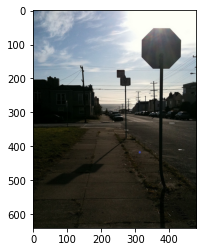

In [ ]:
similarity_score(30,view_image=True)

In [ ]:
# mean cosine similarity of n random test images and their mean
def mean_similarity_n_images(n=10):
  similarities=[]
  randomlist = random.sample(range(0, len(img_name)), n)
  for i in randomlist:
    similarity = similarity_score(verbose=False)
    similarities.append(similarity)
  mean_similarity =sum( similarities)/len(similarities)
  print('mean cosine similarity of {} random images : '.format(n),mean_similarity)
  return similarities , mean_similarity

In [ ]:
result=mean_similarity_n_images()

mean cosine similarity of 10 random images :  0.2026602043250037
